In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.extend(['.', '..'])

import numpy as np
import matplotlib as mpl
from matplotlib import rc
rc('text', usetex='True')
import matplotlib.pyplot as plt
from matplotlib.patches import Circle, Rectangle, Wedge
import matplotlib.colors as mcolors
from matplotlib.legend_handler import HandlerPatch
plt.style.use('./paper.mplstyle')

mpl.rcParams['text.latex.preamble'] = [
    r'\usepackage{amsmath}',
    r'\usepackage{amssymb}',
    r'\usepackage{accents}',
    r'\DeclareSymbolFont{matha}{OML}{txmi}{m}{it}',
    r'\DeclareMathSymbol{\nu}{\mathord}{matha}{118}']
mpl.rcParams['text.latex.unicode'] = True

from scipy import interpolate
from tqdm import tqdm_notebook as tqdm
import shapely.geometry as sg
import shapely.ops as so

import warnings
with warnings.catch_warnings():
    import ternary

    warnings.simplefilter("ignore")
    from utils import fr as fr_utils
    from utils import misc as misc_utils
    from utils import plot as plot_utils

from unitarity import calc_unitarity_bounds

tRed = list(np.array([226,101,95]) / 255.)
tBlue = list(np.array([96,149,201]) / 255.)
tGreen = list(np.array([170,196,109]) / 255.)
grey = list(mcolors.to_rgb('grey'))
nbins = 25
fontsize = 23

In [3]:
class HandlerCircle(HandlerPatch):
    def create_artists(self, legend, orig_handle,
                       xdescent, ydescent, width, height,
                       fontsize, trans):
        r = 10
        x = r + width//2 + 10
        y = height//2 - 3

        # create 
        p = Circle(xy=(x, y), radius=r)

        # update with data from oryginal object
        self.update_prop(p, orig_handle, legend)

        # move xy to legend
        p.set_transform(trans)

        return [p]

In [4]:
s = [1, 2, 0]
SM_120 = [fr_utils.normalise_fr(s), fr_utils.u_to_fr(s, np.array(fr_utils.NUFIT_U, dtype=np.complex128))]
s = [0, 1, 0]
SM_010 = [fr_utils.normalise_fr(s), fr_utils.u_to_fr(s, np.array(fr_utils.NUFIT_U, dtype=np.complex128))]
s = [1, 0, 0]
SM_100 = [fr_utils.normalise_fr(s), fr_utils.u_to_fr(s, np.array(fr_utils.NUFIT_U, dtype=np.complex128))]
print SM_120
print SM_010
print SM_100

SM_X = np.load('./chains/mc_x.npy')

[array([0.33333333, 0.66666667, 0.        ]), array([0.30535346, 0.3527747 , 0.34187184])]
[array([0., 1., 0.]), array([0.18301213, 0.43765598, 0.37933189])]
[array([1., 0., 0.]), array([0.55003613, 0.18301213, 0.26695174])]


In [5]:
# Calculate nufit boundary
polys = []
for x in (SM_X[SM_X[:,0]>=(1/3.)], SM_X[SM_X[:,0]<(1/3.)]):
    polys.append(plot_utils.flavour_contour(
        frs = x,
        plot = False,
        nbins = nbins,
        coverage = 95,
        oversample = 15,
        delaunay = True,
        d_alpha = 0.04,
        d_gauss = 0.02,
        smoothing = 4,
        hist_smooth = 0.03
    ))
p1 = sg.Polygon(polys[0])
p2 = sg.Polygon(polys[1])
nufit_bound = so.cascaded_union([p1,p2]).exterior.xy

../utils/plot.py:288: RuntimeWarning: divide by zero encountered in double_scalars
  circum_r = a*b*c/(4.0*area)
../utils/plot.py:287: RuntimeWarning: invalid value encountered in sqrt
  area = np.sqrt(s*(s-a)*(s-b)*(s-c))
/home/shivesh/programs/anaconda2/lib/python2.7/site-packages/scipy/interpolate/_fitpack_impl.py:226: RuntimeWarning: Setting x[0][300]=x[0][0]
  (i, m, i)))
/home/shivesh/programs/anaconda2/lib/python2.7/site-packages/scipy/interpolate/_fitpack_impl.py:226: RuntimeWarning: Setting x[1][300]=x[1][0]
  (i, m, i)))


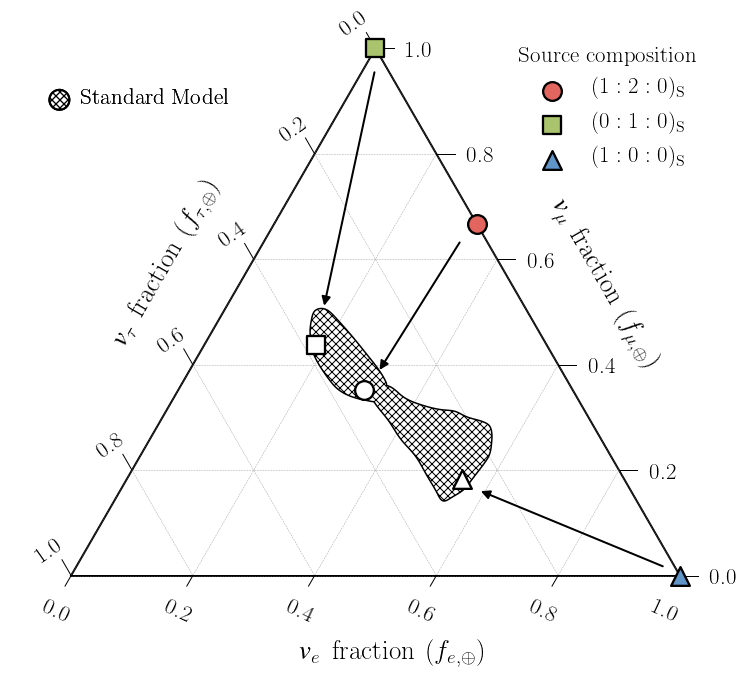

In [15]:
# Figure
fig = plt.figure(figsize=(12, 12))

# Axis
ax = fig.add_subplot(111)
#ax_labels = [r'$f_{e,\oplus}$', r'$f_{\mu,\oplus}$', r'$f_{\tau,\oplus}$']
ax_labels = [r'$\nu_e\:\:{\rm fraction}\:\left( f_{e,\oplus}\right)$',
             r'$\nu_\mu\:\:{\rm fraction}\:\left( f_{\mu,\oplus}\right)$',
             r'$\nu_\tau\:\:{\rm fraction}\:\left( f_{\tau,\oplus}\right)$']
tax = plot_utils.get_tax(ax, scale=nbins, ax_labels=ax_labels, rot_ax_labels=True)

# Plot
tax.scatter([SM_120[0]*nbins], marker='o', s=350, facecolors=tRed,
            edgecolors='k', linewidth=2.3, zorder=10,
            label=r'$(1:2:0\smash{)_{\rm S}}$')
tax.scatter([SM_010[0]*nbins], marker='s', s=350, facecolors=tGreen,
            edgecolors='k', linewidth=2.3, zorder=10,
            label=r'$(0:1:0\smash{)_{\rm S}}$')
tax.scatter([SM_100[0]*nbins], marker='^', s=350, facecolors=tBlue,
            edgecolors='k', linewidth=2.3, zorder=10,
            label=r'$(1:0:0\smash{)_{\rm S}}$')

tax.scatter([SM_120[1]*nbins], marker='o', s=350, edgecolors='k',
            facecolors='white', linewidth=2.3, zorder=10)
tax.scatter([SM_010[1]*nbins], marker='s', s=350, edgecolors='k',
            facecolors='white', linewidth=2.3, zorder=10)
tax.scatter([SM_100[1]*nbins], marker='^', s=350, edgecolors='k',
            facecolors='white', linewidth=2.3, zorder=10)

ax.annotate("", xy=np.array([0.415, 0.44])*nbins, xytext=np.array([0.499, 0.83])*nbins,
            arrowprops=dict(arrowstyle="-|>",facecolor='k',lw=2), zorder=5)
ax.annotate("", xy=np.array([0.505, 0.335])*nbins, xytext=np.array([0.64, 0.55])*nbins,
            arrowprops=dict(arrowstyle="-|>",facecolor='k',lw=2), zorder=5)
ax.annotate("", xy=np.array([0.67, 0.14])*nbins, xytext=np.array([0.975, 0.014])*nbins,
            arrowprops=dict(arrowstyle="-|>",facecolor='k',lw=2), zorder=5)

# Legend
l_size = fontsize
legend = plt.legend(loc=(0.7, 0.75), title=r'Source composition',
                    fontsize=l_size, prop={'size': fontsize})
plt.setp(legend.get_title(), fontsize=l_size)
ax.add_artist(legend)

# Plot NuFIT boundary
ax.fill(
    nufit_bound[0], nufit_bound[1],
    linewidth = 1.5,
    edgecolor = 'None',
    facecolor = 'white',
    alpha = 1,
    zorder = 4,
)
ax.fill(
    nufit_bound[0], nufit_bound[1], 
    linewidth = 1.5,
    edgecolor = 'k',
    facecolor = 'None',
    alpha = 1,
    zorder = 5,
    hatch = 'XXX'
)

legend_elements = []
legend_elements.append(
    Circle((0., 0.), 0.1, facecolor='none', hatch='XXX', edgecolor='k',
           linewidth=2., label=r'Standard Model')
)
legend = plt.legend(handles=legend_elements, loc=(-0.05, 0.85),
                    fontsize=l_size,
                    handler_map={Circle: HandlerCircle()})
plt.setp(legend.get_title(), fontsize=l_size)
legend.get_frame().set_linestyle('-')
ax.add_artist(legend)

fig.savefig('./plots/thesis.pdf', bbox_inches='tight', dpi=150)

In [28]:
# Load chains for Unitary MCMC + HESE contour
SM_120 = np.load('./chains/fr_INJ_1_2_0.npy')
SM_100 = np.load('./chains/fr_INJ_1_0_0.npy')
SM_010 = np.load('./chains/fr_INJ_0_1_0.npy')

bc_chains = np.load('./chains/contour_REAL.npy')
flavour_angles = bc_chains[:,-2:]
flavour_ratios = np.array(
    map(fr_utils.angles_to_fr, flavour_angles)
)

In [29]:
# Only plot n points
n = 8000
SM_120 = SM_120[:n]
SM_100 = SM_100[:n]
SM_010 = SM_010[:n]

In [20]:
f_s_120 = fr_utils.normalise_fr((1, 2, 0))
f_s_010 = fr_utils.normalise_fr((0, 1, 0))
f_s_100 = fr_utils.normalise_fr((1, 0, 0))

In [21]:
n_samples = 1000
f_m_120 = calc_unitarity_bounds(f_s_120, n_samples)
f_m_010 = calc_unitarity_bounds(f_s_010, n_samples)
f_m_100 = calc_unitarity_bounds(f_s_100, n_samples)

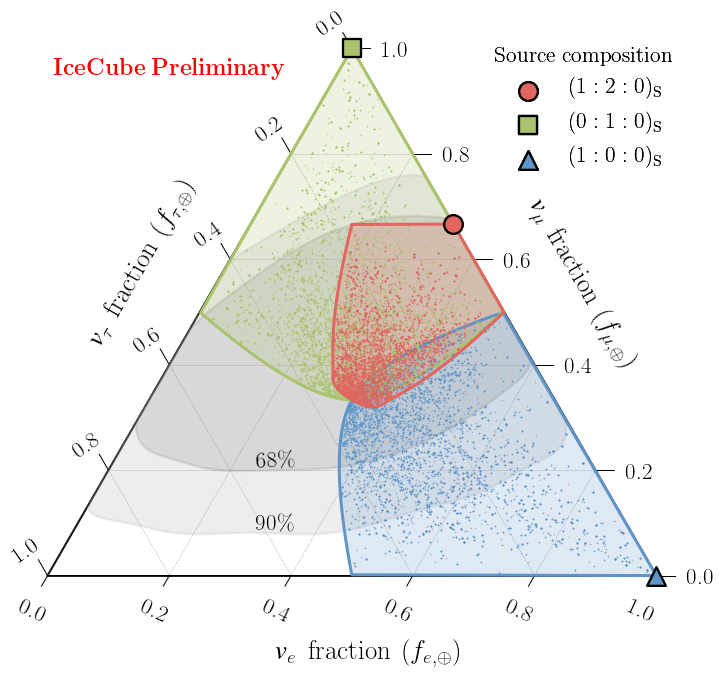

In [30]:
# Figure
fig = plt.figure(figsize=(12, 12))

# Axis
ax = fig.add_subplot(111)
#ax_labels = [r'$f_{e,\oplus}$', r'$f_{\mu,\oplus}$', r'$f_{\tau,\oplus}$']
ax_labels = [r'$\nu_e\:\:{\rm fraction}\:\left( f_{e,\oplus}\right)$',
             r'$\nu_\mu\:\:{\rm fraction}\:\left( f_{\mu,\oplus}\right)$',
             r'$\nu_\tau\:\:{\rm fraction}\:\left( f_{\tau,\oplus}\right)$']
tax = plot_utils.get_tax(ax, scale=nbins, ax_labels=ax_labels, rot_ax_labels=True)

# Plot source dots
tax.scatter([f_s_120*nbins], marker='o', s=350, facecolors=tRed,
            edgecolors='k', linewidth=2.3, zorder=10,
            label=r'$(1:2:0\smash{)_{\rm S}}$')
tax.scatter([f_s_010*nbins], marker='s', s=350, facecolors=tGreen,
            edgecolors='k', linewidth=2.3, zorder=10,
            label=r'$(0:1:0\smash{)_{\rm S}}$')
tax.scatter([f_s_100*nbins], marker='^', s=350, facecolors=tBlue,
            edgecolors='k', linewidth=2.3, zorder=10,
            label=r'$(1:0:0\smash{)_{\rm S}}$')

# Plot unitary boundaries
for f_m, col, zorder in reversed(zip((f_m_120, f_m_010, f_m_100), (tRed, tGreen, tBlue), (9, 5, 5))):
    plot_utils.tax_fill(
        ax=ax,
        points=f_m,
        nbins=nbins,
        facecolor = col+[0.2],
        edgecolor = None,
        zorder = 5
    )
    tax.plot(
        f_m*nbins,
        linewidth = 3,
        color = col,
        zorder = zorder
    )

# Plot unitary points
tax.scatter(SM_120*nbins, marker='.', s=2, alpha=0.5, color=tRed, zorder=8)
tax.scatter(SM_010*nbins, marker='.', s=2, alpha=0.5, color=tGreen, zorder=7)
tax.scatter(SM_100*nbins, marker='.', s=2, alpha=0.5, color=tBlue, zorder=6)
    
# Legend
l_size = fontsize
legend = plt.legend(loc=(0.7, 0.75), title=r'Source composition',
                    fontsize=l_size, prop={'size': fontsize})
plt.setp(legend.get_title(), fontsize=l_size)
ax.add_artist(legend)

# Plot HESE contour
coverages = {68: 'grey', 90: 'darkgrey'}
for cov in coverages.iterkeys():
    plot_utils.flavour_contour(
        frs = flavour_ratios,
        fill = True,
        ax = ax,
        nbins = nbins,
        coverage = cov,
        linewidth = 2.5,
        color = coverages[cov],
        alpha = 0.2,
        zorder = 4
    )
# Text
ax.text(0.34*nbins, 0.18*nbins, r'$68\%$', fontsize=fontsize, rotation=3, zorder=6)
ax.text(0.34*nbins, 0.075*nbins, r'$90\%$', fontsize=fontsize, rotation=0, zorder=6)
fig.text(
    0.3, 0.8, r'${\rm\bf IceCube\:Preliminary}$', fontsize=fontsize,
    horizontalalignment='center', color='r'
)

fig.savefig('./plots/unitarity.pdf', bbox_inches='tight', dpi=150)